In [1]:
import numpy as np
import sys
from os.path import expanduser
from scipy import ndimage
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.wcs import WCS
import matplotlib
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import warnings
import math
#warnings.filterwarnings('ignore')

## Relative folder

In [2]:
home = expanduser("~")
datafolder=home+'/Desktop/mrk79/'  #The folder containing your .fits file
datafolder

'/home/apostolis/Desktop/mrk79/'

## Open fits file

In [3]:
mrk79_file='COcube.fits' #.fits file name
mrk79_fits=fits.open(datafolder+mrk79_file)[0]

## Fits header

In [4]:
mrk79_header=mrk79_fits.header
mrk79_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                   97                                                  
NAXIS2  =                   97                                                  
NAXIS3  =                  190                                                  
NAXIS4  =                    1                                                  
DATAMIN = -0.6655395496637E-02         /                                        
DATAMAX =  0.2891516312957E-01         /                                        
BUNIT   = 'Jy/beam     '               /                                        
CTYPE1  = 'RA---ARC    '               /                                        
CRVAL1  =  0.1156366666667E+03         /                                        
CDELT1  = -0.1731111137690E-

## Data

In [5]:
mrk79_data=mrk79_fits.data
print(f'Shape of data is {mrk79_data.shape}, so this is not a cube, it has an extra dimension without a reason')
mrk79_data=mrk79_data[0]
print(f'Shape of data is {mrk79_data.shape}, seems fine, the dimensions is (z,y,x) (there is a (computation speed) reason for this, so it is better to keep this structure)')

Shape of data is (1, 190, 97, 97), so this is not a cube, it has an extra dimension without a reason
Shape of data is (190, 97, 97), seems fine, the dimensions is (z,y,x) (there is a (computation speed) reason for this, so it is better to keep this structure)


### Calculate the coordinates
From the header the z coordinate has velocity dimensions ```CTYPE3  = 'VRAD'``` in km/s ```CUNIT3  = 'km/s'```

From the header the x,y coordinates has RA/DEC dimensions ```CTYPE1  = 'RA---ARC'```,```CTYPE2  = 'DEC--ARC'``` in degrees```CUNIT1  = 'deg'```

In [6]:
dx = np.abs(mrk79_header['CDELT1'])*3600 #arcsec
dy = np.abs(mrk79_header['CDELT2'])*3600 #arcsec
dv = mrk79_header['CDELT3'] #km/s

ydec=np.linspace(-mrk79_data.shape[1]*dy/2. +mrk79_header["CRVAL2"],mrk79_data.shape[1]*dy/2.+mrk79_header["CRVAL2"],mrk79_header['NAXIS2'])
xra=np.linspace(-mrk79_data.shape[2]*dx/2. +mrk79_header["CRVAL1"],mrk79_data.shape[2]*dx/2.+mrk79_header["CRVAL1"],mrk79_header['NAXIS1'])

xx=np.linspace(-mrk79_data.shape[2]*dx/2.,mrk79_data.shape[2]*dx/2.,mrk79_header['NAXIS1']) #arcsec
yy=np.linspace(-mrk79_data.shape[1]*dx/2.,mrk79_data.shape[1]*dx/2.,mrk79_header['NAXIS2']) #arcsec

b=mrk79_header['CRVAL3']-mrk79_header['CRPIX3']*dv #zero point velocity
vv=np.linspace(b+dv,b+dv*mrk79_header['NAXIS3'],mrk79_header['NAXIS3'])  #velocity channels

### Make some plots

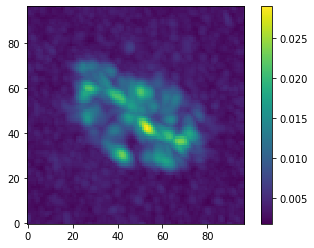

In [7]:
mrk79_max = np.nanmax(mrk79_data,axis=0) #collapse the cube along 0 dimension (velocity) by keeping only the maximum velocities 
plt.imshow(mrk79_max,origin='low')
plt.colorbar()# Image plot, dimensions are pixels

/home/apostolis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


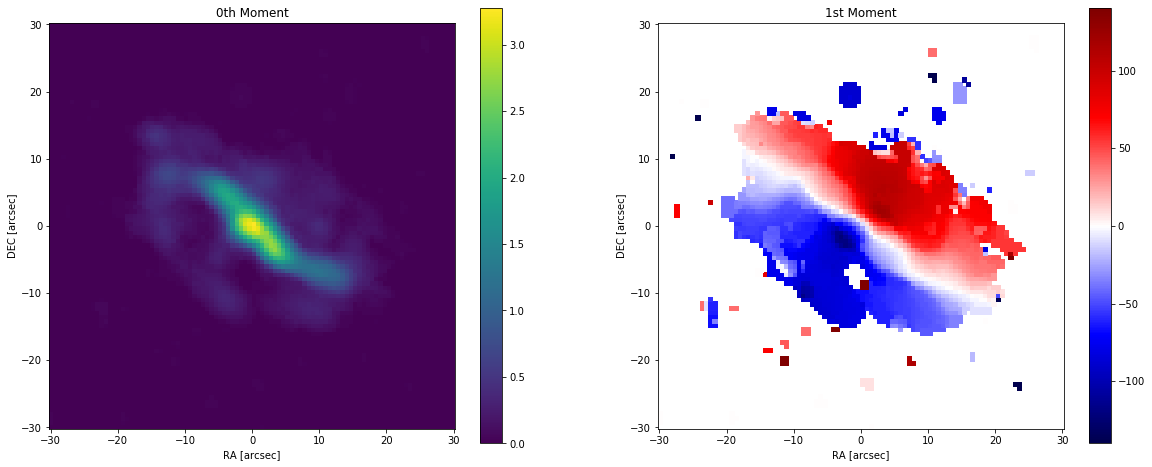

In [8]:
sigma=9.3859574E-4 #noise [Jy/beam]
fig, axes = plt.subplots(1,2,figsize=(20,8))
mrk79_mom0 = np.nansum(np.where(mrk79_data>=5*sigma,mrk79_data,0),axis=0)*np.abs(dv) #collapse the cube along 0 dimension (velocity) by summing (zeroth moment)
vv2=np.linspace(0,0,mrk79_header["NAXIS3"])
for i in range(190):
    vv2[i]=np.where(-300<=vv[i] and vv[i]<=300,vv[i],0)
mrk79_mom1=np.nansum(vv2[:,None,None]*np.where(mrk79_data>=5*sigma,mrk79_data,0),axis=0)/(mrk79_mom0/np.abs(dv)) #first moment
p0=axes[0].pcolormesh(xx,yy,mrk79_mom0,vmin=0)
axes[0].set(aspect=1,xlabel='RA [arcsec]',ylabel='DEC [arcsec]',title='0th Moment')
fig.colorbar(p0, ax=axes[0])

p1=axes[1].pcolormesh(xx,yy,mrk79_mom1,vmin=-140,vmax=140,cmap='seismic')
axes[1].set(aspect=1,xlabel='RA [arcsec]',ylabel='DEC [arcsec]',title='1st Moment')
fig.colorbar(p1, ax=axes[1])


### Extra: Calculate the intrinsic dimensions

arcsec to kpc conversion: 0.4630279249450416 kpc / arcsec
distance to mrk79: 99.79205841490912 Mpc


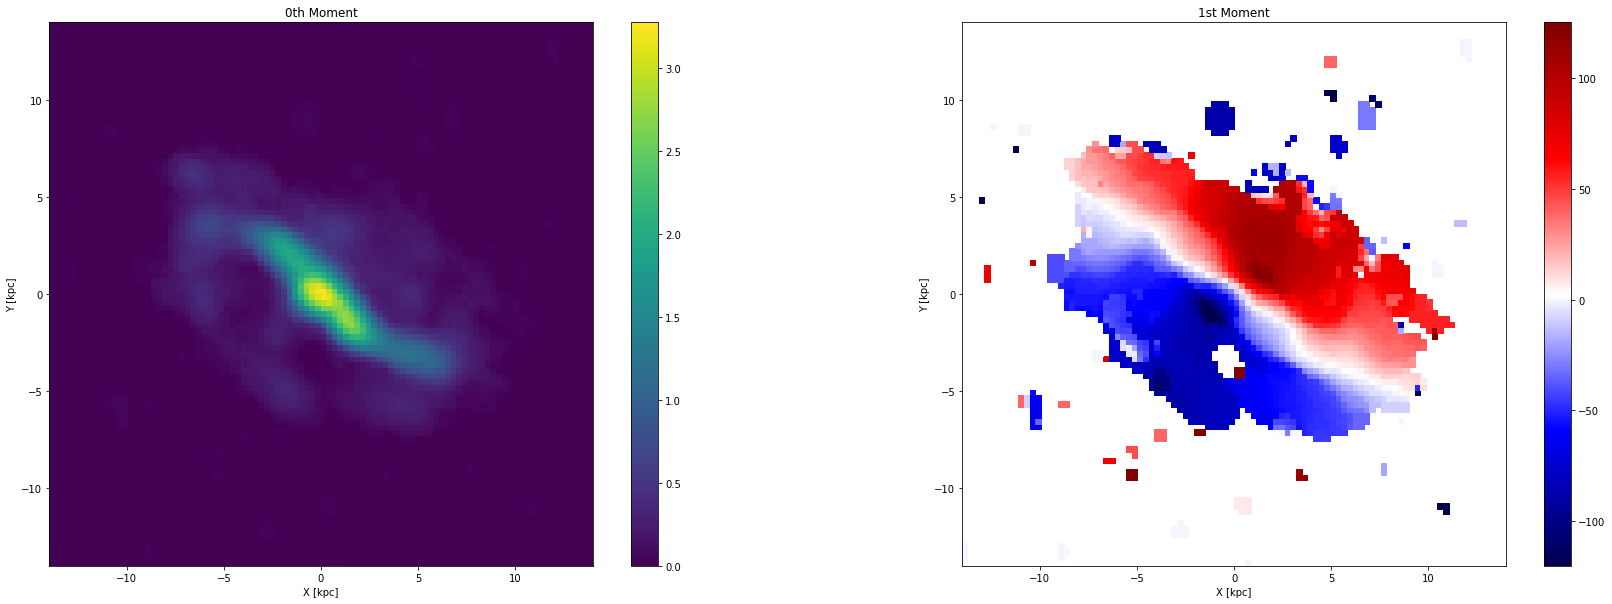

In [9]:
import astropy.units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=67.8, Om0=0.3,Ode0=0.7) #create a cosmology
z=0.02219  #redshit
D=cosmo.luminosity_distance(z) #distance to the object
arctokpc = (cosmo.angular_diameter_distance(z=z)/206265).to(u.kpc)/u.arcsec
print("arcsec to kpc conversion:",arctokpc)
ak=arctokpc.value
print("distance to mrk79:",D)

xx_kpc=xx*ak
yy_kpc=yy*ak

fig, axes = plt.subplots(1,2,figsize=(30,10))

p0=axes[0].pcolormesh(xx_kpc,yy_kpc,mrk79_mom0)
axes[0].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='0th Moment')
fig.colorbar(p0, ax=axes[0])

p1=axes[1].pcolormesh(xx_kpc,yy_kpc,mrk79_mom1,vmin=-120,vmax=125,cmap='seismic')
axes[1].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='1st Moment')
fig.colorbar(p1, ax=axes[1])

## Position Velocity Plots

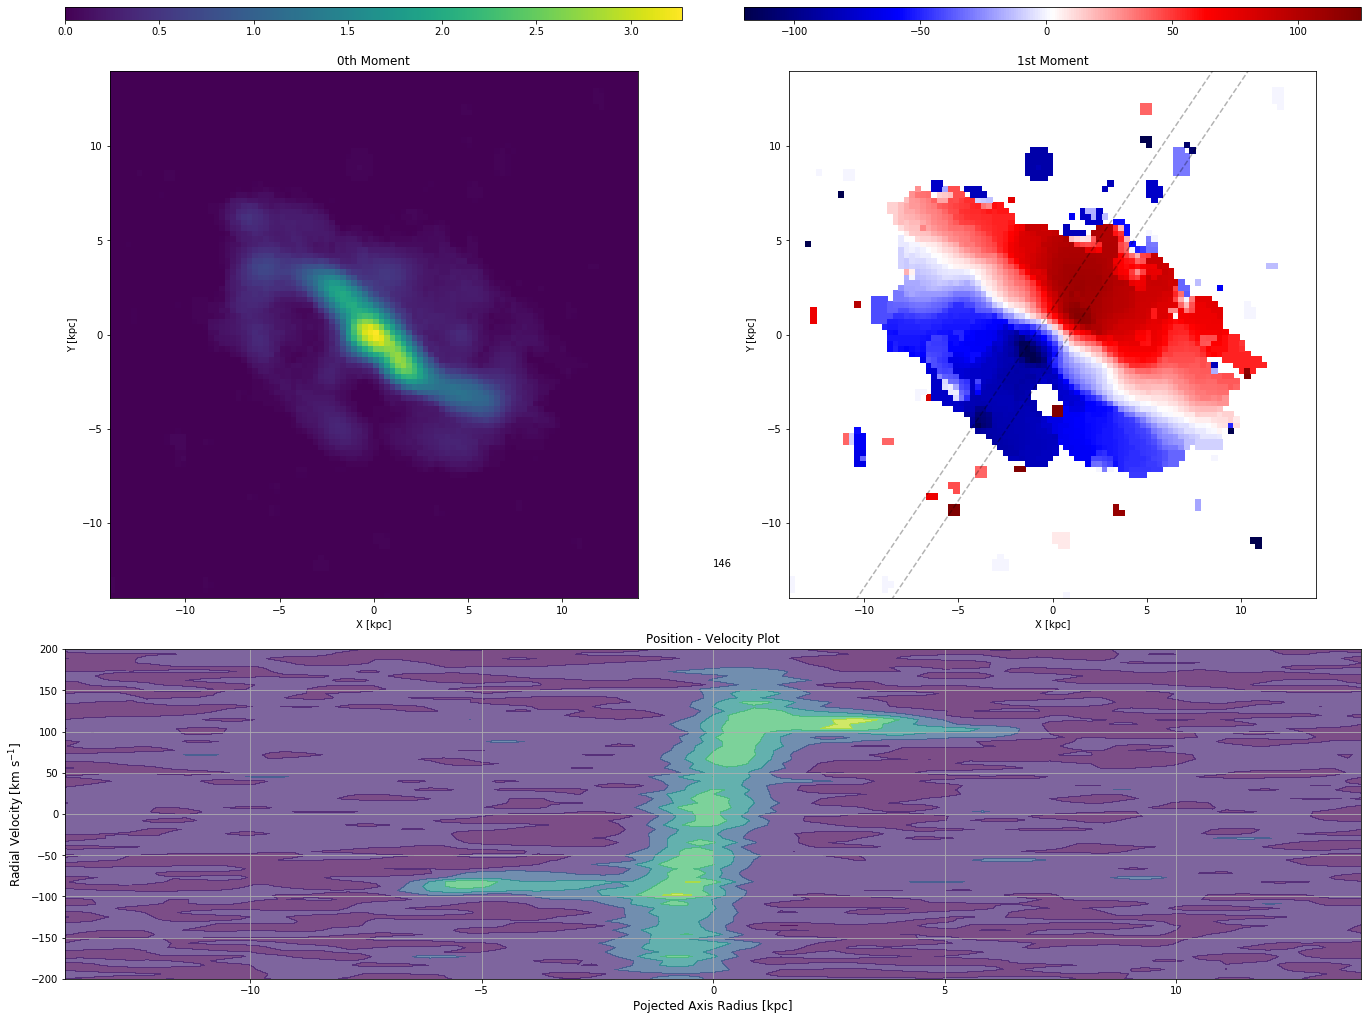

In [10]:
import matplotlib.gridspec as gridspec

papvds = [146]
dx_kpc=(dx)*ak #dx in kpc
slit=0.9377271654521E-03*ak*3600 #slit width in kpc

limy=[np.min(yy_kpc),np.max(yy_kpc)]
limv=[-200,200]

Nplots=len(papvds)
Ncubes = 1
fig = plt.figure(figsize=(20,10+5*Nplots))
gs=gridspec.GridSpec(2+Nplots, 2*Ncubes, height_ratios=[0.02,0.8]+[0.5]*Nplots, width_ratios=[0.8,0.8]*Ncubes)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

ipx=0
axmom0 = fig.add_subplot(gs[1,ipx])
caxmom0 = fig.add_subplot(gs[0,ipx])
ipx=ipx+1
axmom1 = fig.add_subplot(gs[1,ipx])
caxmom1 = fig.add_subplot(gs[0,ipx])

cm0=axmom0.pcolormesh(xx_kpc,yy_kpc,mrk79_mom0)
plt.colorbar(cm0,cax=caxmom0,orientation='horizontal').ax.tick_params(labelsize=10)
axmom0.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='0th Moment')  

cm1=axmom1.pcolormesh(xx_kpc,yy_kpc,mrk79_mom1,vmin=-120,vmax=125,cmap='seismic')
plt.colorbar(cm1,cax=caxmom1,orientation='horizontal').ax.tick_params(labelsize=10)  
axmom1.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='1st Moment')   

ithick = int(round(slit/dx_kpc)) #number of pixels which are going to collapse (inside the slit)
ixc = round(mrk79_data.shape[2]/2) #where is the center in pixels

for j,papvd in enumerate(papvds):
    
    #Create and Plot the Slit(s)
    def yslit_low(x): return slit/(2*np.cos(np.radians(papvd+90))) +x*np.tan(np.radians(papvd+90))
    def yslit_high(x): return -slit/(2*np.cos(np.radians(papvd+90))) +x*np.tan(np.radians(papvd+90))
    axmom1.plot(xx_kpc,yslit_low(xx_kpc),'--',alpha=0.3, color='black')
    axmom1.plot(xx_kpc,yslit_high(xx_kpc),'--',alpha=0.3, color='black')
    axmom1.set(xlim=[np.min(xx_kpc),np.max(xx_kpc)],ylim=[np.min(yy_kpc),np.max(yy_kpc)])   

    axpvd = fig.add_subplot(gs[2+j,:])
    axpvd.text(x=np.mean(limy),y=300,s="{}".format(papvd))
    axpvd.set(title='Position - Velocity Plot')
    axpvd.set_xlabel('Pojected Axis Radius [kpc]',fontsize=12)
    axpvd.set_ylabel(r'Radial Velocity [km s$^{-1}$]',fontsize=12)

    axpvd.set_xlim(limy)
    axpvd.set_ylim(limv)
    axpvd.grid(True)
    
    #Create the Position-Velocity Graph
    rotcube=ndimage.interpolation.rotate(mrk79_data,papvd+180,axes=(2,1),reshape=False) #rotate the cube along 0 dimension
    
    #collapse the slit by summing 
    pvd_cube = np.nansum(rotcube[:,:,ixc-int(ithick/2):ixc+int(ithick/2)],axis=2)
    ppvd_res=axpvd.contourf(yy_kpc,vv,pvd_cube,alpha=0.7,vmin=0)

### 2nd Moment

/home/apostolis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


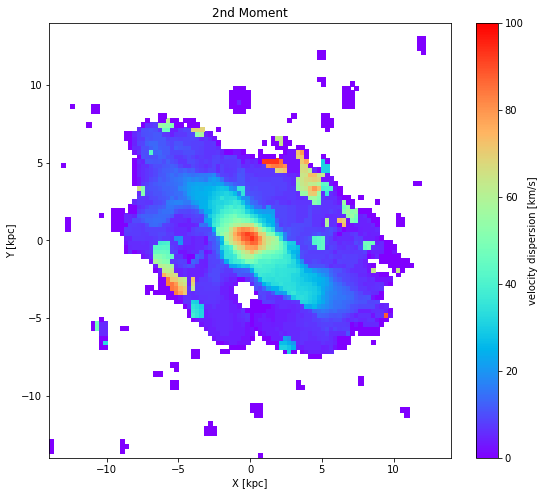

In [11]:
mrk79_mom2=np.sqrt(np.nansum(np.where(mrk79_data>=5*sigma,mrk79_data,0)*(vv2[:,None,None]-mrk79_mom1)**2,axis=0)/(mrk79_mom0/np.abs(dv)))
plt.figure(figsize=(9,8))
plt.pcolormesh(xx_kpc,yy_kpc,mrk79_mom2,vmin=0,vmax=100, cmap='rainbow')
plt.colorbar(label='velocity dispersion [km/s]')
#plt.contour(xx_kpc,yy_kpc,mrk79_mom2,cmap='gray')
plt.xlabel("X [kpc]"), plt.ylabel("Y [kpc]")
plt.title("2nd Moment")
plt.show()

### Inclination & Mass

In [12]:
from astropy import constants as const

GG=const.G.to('kpc3 / (kg s2)')
G=GG.value
vmax=122 #maximum rotational velocity corrected for inclination (HyperLeda)
vmax_kpc=(vmax*(u.km/u.s)).to(u.kpc/u.s)
a=(30.90)*ak #semi-major axis in kpc (2MASS)
"""
    a=(30.90)*ak #semi-major axis in kpc (2MASS)
    da=0.33*ak
    b=(16.068)*ak #semi-minor axis in kpc (2MASS)
    db=0.33*ak
    sini=np.sqrt(1-(b/a)**2) #inclination
    dsini=(b/(a**2*sini))*np.sqrt((da*b/a)**2 + db**2)
    di=np.rad2deg(np.arcsin(dsini))
"""
inc=36.7    
sini=np.sin(np.deg2rad(inc)) #<---This is the inclination
cosi=np.cos(np.deg2rad(inc))
print("the inclination is i =","{:.4}".format(np.rad2deg(np.arcsin(sini))))  #,"+-","{:.2}".format(di),"deg")

Mkg=(a*(vmax_kpc.value)**2)/G
Msun=Mkg/const.M_sun.value

print("Mass of mrk79 =","{:.2e}".format(Msun),"M_sun")

the inclination is i = 36.7
Mass of mrk79 = 4.95e+10 M_sun


### Calculate the a parameter from the maximum velocity 

 a0  =  3.79 kpc


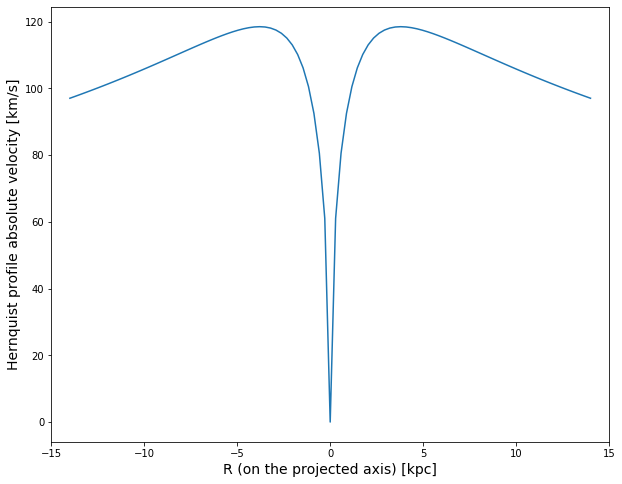

In [13]:
rr=yy_kpc
for a0 in enumerate(rr):
    vc=np.sqrt(G*Mkg*np.abs(rr))/(np.abs(rr)+np.abs(a0[1]))
    vc=((vc*(u.kpc/u.s)).to(u.km/u.s)).value
    if (vmax-4.7)<=np.max(vc) and np.max(vc)<=(vmax+4.7): 
        break
plt.figure(figsize=(10,8))
plt.plot(rr,vc)
plt.xlim(-15,15), plt.xlabel("R (on the projected axis) [kpc]",fontsize=14), plt.ylabel("Hernquist profile absolute velocity [km/s]",fontsize=14)
print(" a0  = ","{:.3}".format(np.abs(a0[1])),"kpc")


### Bertola model 

In [14]:
from scipy.optimize import curve_fit

def bertola(r,A,c,p):
    vc=A*r/((r**2+c**2)**(p/2))
    vc=vc*sini
    return vc
def bertfit1d(velo,rr,inparam):
    popt, pcov = curve_fit(bertola,rr,velo,p0=inparam)
    print('parameters of Bertola model: A=',"{:.5}".format(popt[0]),', c=',"{:.5}".format(popt[1]),', p=',"{:.5}".format(popt[2]))
    return popt

### Fitting of 1st Moment with the Hernquist profile

/home/apostolis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


parameter a calculated from least squares fitting of Hernquist model: a= 5.6855142 kpc

parameters of Bertola model: A= 303.35 , c= -1.3396 , p= 1.4034


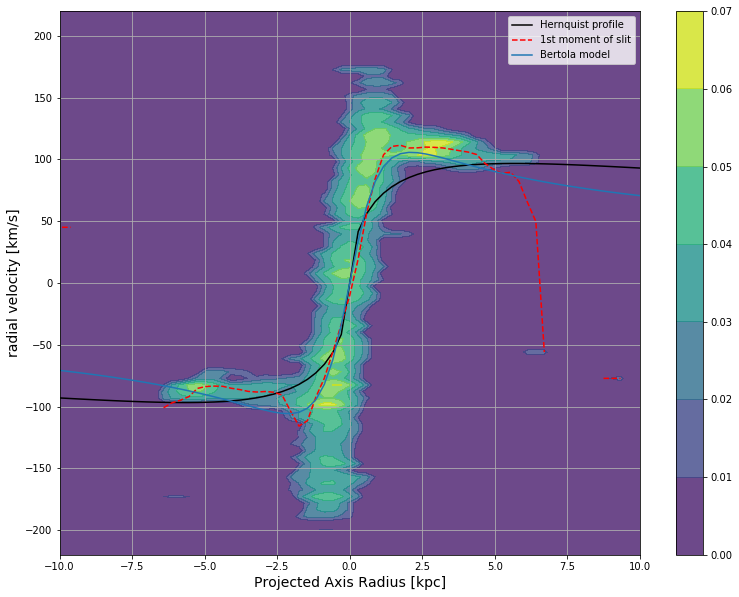

In [15]:

#Removing less than 5*sigma Intensities 
pvd_cubec=np.nansum(np.where(rotcube[:,:,ixc-int(ithick/2):ixc+int(ithick/2)]>=5*sigma,rotcube[:,:,ixc-int(ithick/2):ixc+int(ithick/2)],0),axis=2)

#if you don't want to remove low intensities just uncomment the line below 
#pvd_cubec=pvd_cube

mom0slit=np.nansum(pvd_cubec,axis=0)*np.abs(dv)
mom1slit=np.nansum(vv[:,None]*pvd_cubec,axis=0)/(mom0slit/np.abs(dv))

mom1slitc=mom1slit/sini

def hern(r,a0): #Hernquist model velocity function
    vc=np.sqrt(G*Mkg*np.abs(r))/(np.abs(r)+np.abs(a0))
    vc=((vc*(u.kpc/u.s)).to(u.km/u.s)).value
    return vc

def errfhern(vh,velo): #error function of one position
    errf=np.nansum(np.abs(vh-np.abs(velo))**2,axis=0)
    return errf

def hernfit(velo):
    param_a=np.linspace(0,np.max(yy_kpc),len(yy_kpc)) #parameter a
    sum_err=np.linspace(0,0,len(param_a))

    for j, a00 in enumerate(param_a):
        vhern=hern(yy_kpc,a00)
    
        for i in range(len(yy_kpc)):
            sum_err[j]=sum_err[j]+errfhern(vhern[i],velo[i])
        sum_err[j]=((sum_err[j]))
    
    index_of_min_a0=np.where(sum_err==np.min(sum_err))  
    a0_min=param_a[index_of_min_a0]
    return a0_min

plt.figure(figsize=(13,10))
plt.plot(yy_kpc,np.where(yy_kpc<=0,-hern(yy_kpc,hernfit(mom1slit)),hern(yy_kpc,hernfit(mom1slit))),'k',label='Hernquist profile')
plt.plot(yy_kpc,mom1slit,'r--',label='1st moment of slit')
plt.contourf(yy_kpc,vv,pvd_cubec,alpha=0.8)
plt.colorbar()
plt.grid(), plt.xlim(-10,10), plt.ylim(-220,220), plt.xlabel('Projected Axis Radius [kpc]',fontsize=14), plt.ylabel('radial velocity [km/s]',fontsize=14)

print('parameter a calculated from least squares fitting of Hernquist model: a=',"{:.8}".format(hernfit(mom1slit)[0]),'kpc\n')

m2=mom1slit[26:70]
m2=np.where(np.isnan(m2),0,m2)
init_param=[100,5,1]
bertolaparam=bertfit1d(m2,yy_kpc[26:70],init_param)

plt.plot(yy_kpc,bertola(yy_kpc,bertolaparam[0],bertolaparam[1],bertolaparam[2]),label='Bertola model')
plt.legend()
plt.show()

### Fitting every pixel spectrum with a Gaussian

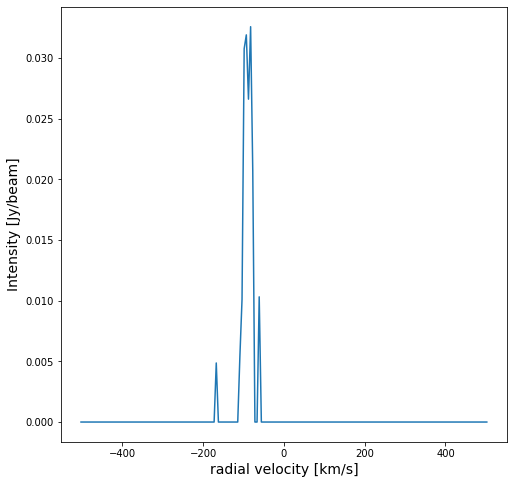

In [16]:
plt.figure(figsize=(8,8))
plt.plot(vv,pvd_cubec[:,40]) #Spectrum of one pixel
plt.xlabel('radial velocity [km/s]',fontsize=14), plt.ylabel('Intensity [Jy/beam]',fontsize=14)
plt.show()

/home/apostolis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/apostolis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/apostolis/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/apostolis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/apostolis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


parameter a calculated from least squares fitting of Hernquist model: a = 5.3939494 kpc 

parameters of Bertola model: A= 304.75 , c= -1.238 , p= 1.4216


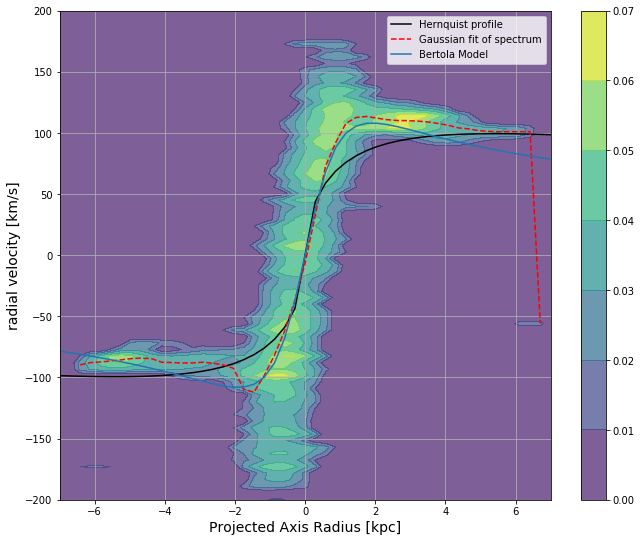

In [17]:
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

def gaus(x,a,x0,sigma):
    return a * np.exp(-(x-x0)**2/(2 * sigma**2))                                               

vv_slit=np.linspace(0,0,len(yy_kpc))                                                            

for k in range(len(yy_kpc)):
    mean=np.nansum(vv*pvd_cubec[:,k])/np.nansum(pvd_cubec[:,k])
    sig=np.sqrt(np.nansum(pvd_cubec[:,k] * (vv - mean)**2) /np.nansum(pvd_cubec[:,k]))
    popt,pcov = curve_fit(gaus,vv,pvd_cubec[:,k],p0=[np.nanmax(pvd_cubec[:,k]),mean,sig])
    vv_slit[k]=popt[1]

print('parameter a calculated from least squares fitting of Hernquist model: a =',"{:.8}".format(hernfit(vv_slit)[0]),'kpc \n')

plt.figure(figsize=(11,9))

plt.plot(yy_kpc,np.where(yy_kpc<=0,-hern(yy_kpc,hernfit(vv_slit)),hern(yy_kpc,hernfit(vv_slit))),'k',label='Hernquist profile')
plt.plot(yy_kpc,vv_slit,'r--',label='Gaussian fit of spectrum')

plt.contourf(yy_kpc,vv,pvd_cubec,alpha=0.7), plt.colorbar()
plt.xlim(-7,7), plt.ylim(-200,200), plt.grid()
plt.xlabel('Projected Axis Radius [kpc]',fontsize=14), plt.ylabel('radial velocity [km/s]',fontsize=14)

vv_slit2=np.where(np.isnan(vv_slit[25:70]),0,vv_slit[25:70])
bert_param=bertfit1d(vv_slit2,yy_kpc[25:70],[100,5,1])
plt.plot(yy_kpc,bertola(yy_kpc,bert_param[0],bert_param[1],bert_param[2]),label='Bertola Model')
plt.legend()
plt.show()

### Rotation Curve from mean and maximum Intensities

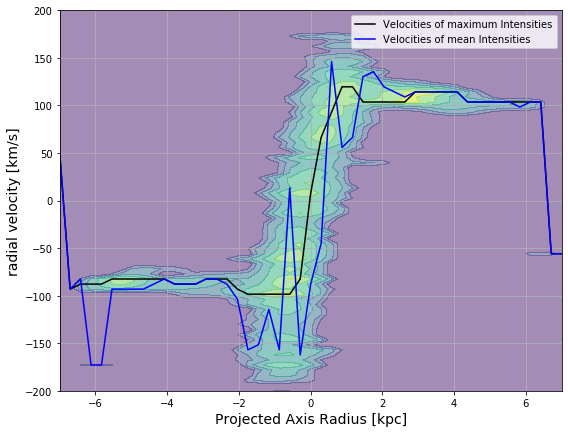

For maximum Intensities:

parameter a calculated from least squares fitting of Hernquist model: a = 5.6855142 kpc

parameters of Bertola model: A= 184.55 , c= 0.35522 , p= 1.0959

For mean Intensities:

parameter a calculated from least squares fitting of Hernquist model: a = 4.3734725 kpc

parameters of Bertola model: A= 217.66 , c= 0.70224 , p= 1.1294


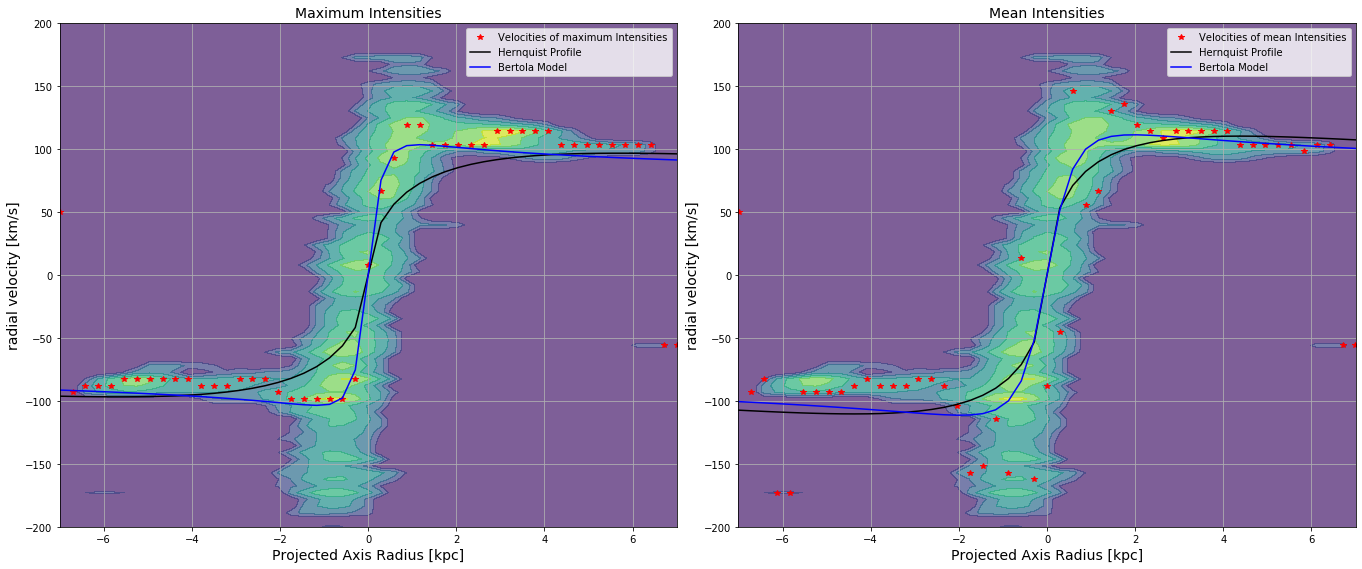

In [18]:
pvd_cubemax=np.linspace(0,0,mrk79_header['NAXIS1'])
pvd_cubemean=np.linspace(0,0,mrk79_header['NAXIS1'])

vmaxslit=np.linspace(0,0,mrk79_header['NAXIS1'])
vmeanslit=np.linspace(0,0,mrk79_header['NAXIS1'])

index=np.linspace(0,0,mrk79_header['NAXIS1'])
index2=np.linspace(0,0,mrk79_header['NAXIS1'])

for k in range(mrk79_header['NAXIS1']):
    for m in range(mrk79_header['NAXIS3']):
        if pvd_cubemax[k]<=pvd_cube[m,k]:
            pvd_cubemax[k]=pvd_cube[m,k]
            index[k]=m
        vmaxslit[k]=vv[int(index[k])]

for i in range(mrk79_header['NAXIS1']):
    pvd_cubemean[i]=np.nansum(pvd_cube[:,i]**2,axis=0)/np.nansum(pvd_cube[:,i],axis=0)
    diff=np.abs(pvd_cubemean[i]-pvd_cube[0,i])
    index2[i]=0 
    for k in range(mrk79_header['NAXIS3']):
        if diff>=np.abs(pvd_cubemean[i]-pvd_cube[k,i]):
            diff=np.abs(pvd_cubemean[i]-pvd_cube[k,i])
            index2[i]=k
    vmeanslit[i]=vv[int(index2[i])]   

plt.figure(figsize=(9,7))
plt.contourf(yy_kpc,vv,pvd_cubec,alpha=0.5)
plt.plot(yy_kpc,vmaxslit,'k',label='Velocities of maximum Intensities')
plt.plot(yy_kpc,vmeanslit,'b',label='Velocities of mean Intensities')
plt.legend()
plt.xlim(-7,7), plt.ylim(-200,200), plt.grid()
plt.xlabel('Projected Axis Radius [kpc]',fontsize=14), plt.ylabel('radial velocity [km/s]',fontsize=14)
plt.show()

print('\033[1m'+'For maximum Intensities:\n'+'\033[0m')
print('parameter a calculated from least squares fitting of Hernquist model: a =',"{:.8}".format(hernfit(vmaxslit)[0]),'kpc\n')
bert_paramax=bertfit1d(vmaxslit[25:70],yy_kpc[25:70],[300,4,1.5])

print('\033[1m'+'\nFor mean Intensities:\n'+'\033[0m')
print('parameter a calculated from least squares fitting of Hernquist model: a =',"{:.8}".format(hernfit(vmeanslit)[0]),'kpc\n')
bert_paramean=bertfit1d(vmeanslit[25:70],yy_kpc[25:70],[300,4,1.5])

fig = plt.figure(figsize=(20,20))
gs=gridspec.GridSpec(4, 2, height_ratios=[0.02,0.8]+[0.5]*2, width_ratios=[0.8,0.8])
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

axvelo_max = fig.add_subplot(gs[1,0])
axvelo_max.plot(yy_kpc,vmaxslit,'r*',label='Velocities of maximum Intensities')
axvelo_max.plot(yy_kpc,np.where(yy_kpc<=0,-hern(yy_kpc,hernfit(vmaxslit)),hern(yy_kpc,hernfit(vmaxslit))),'k',label='Hernquist Profile')
axvelo_max.plot(yy_kpc,bertola(yy_kpc,bert_paramax[0],bert_paramax[1],bert_paramax[2]),'b', label='Bertola Model')
plt.legend()
axvelo_max.contourf(yy_kpc,vv,pvd_cubec,alpha=0.7)
plt.xlabel('Projected Axis Radius [kpc]',fontsize=14), plt.ylabel('radial velocity [km/s]',fontsize=14)
plt.xlim(-7,7), plt.ylim(-200,200), plt.grid()
plt.title('Maximum Intensities', fontsize=14)

axvelo_mean = fig.add_subplot(gs[1,1])
axvelo_mean.plot(yy_kpc,vmeanslit,'r*',label='Velocities of mean Intensities')
axvelo_mean.plot(yy_kpc,np.where(yy_kpc<=0,-hern(yy_kpc,hernfit(vmeanslit)),hern(yy_kpc,hernfit(vmeanslit))),'k',label='Hernquist Profile')
axvelo_mean.plot(yy_kpc,bertola(yy_kpc,bert_paramean[0],bert_paramean[1],bert_paramean[2]),'b', label='Bertola Model')
plt.legend()
axvelo_mean.contourf(yy_kpc,vv,pvd_cubec,alpha=0.7)
plt.xlabel('Projected Axis Radius [kpc]',fontsize=14), plt.ylabel('radial velocity [km/s]',fontsize=14)
plt.xlim(-7,7), plt.ylim(-200,200), plt.grid()
plt.title('Mean Intensities', fontsize=14)
plt.show()

### Bertola velocity field for A,c,p from the 1D fit

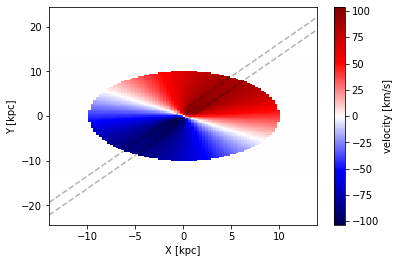

In [19]:
import matplotlib.pyplot as plt
from matplotlib import cm
def bert_m1(x,y,A,c,p,i):
    cos=np.cos(np.deg2rad(i))
    sin=np.sin(np.deg2rad(i))
    ang=np.rad2deg(np.arctan(x/y))-146+90
    ang=np.deg2rad(ang)
    R=np.sqrt(x**2+y**2)
    if R<=10:
        mom1=(A*R*np.cos(ang)*sin*(cos**p))/(((R**2)*(np.sin(ang)**2+(cos**2)*np.cos(ang)**2)+(c**2)*cos**2)**(p/2))
    else: mom1=0
    if x>0 and y>0:
        mom1=np.abs(mom1)
    if x<0 and y<0:
        mom1=-np.abs(mom1)
    if y<0 and x>0:
        mom1=-mom1
    return mom1                                     
tax=np.zeros(shape=(97,97))
for i in range(len(xx_kpc)):
    for j in range(len(yy_kpc)):
            tax[i,j]=bert_m1(xx_kpc[i],yy_kpc[j],bert_paramax[0],bert_paramax[1],bert_paramax[2],inc)
plt.pcolormesh(xx_kpc,yy_kpc,tax,cmap='seismic')
plt.colorbar(label='velocity [km/s]'),plt.xlabel("X [kpc]"),plt.ylabel("Y [kpc]")
plt.plot(xx_kpc,yslit_low(xx_kpc),'--',alpha=0.3, color='black')
plt.plot(xx_kpc,yslit_high(xx_kpc),'--',alpha=0.3, color='black')

### Bertola Velocity Field

In [20]:
# This is the function used to do the fit
def velf_bert(xy_mesh,incl,pa): # xy_mesh is not used inside the function, it is just needed for the curve_fit function 
    A=bert_paramax[0]
    c=bert_paramax[1]
    p=bert_paramax[2]    
    cosin=np.cos(np.deg2rad(incl))
    sinin=np.sin(np.deg2rad(incl))
    R,ang,g=np.zeros(shape=(97,97)),np.zeros(shape=(97,97)),np.zeros(shape=(97,97))

    for i in range(97):
        for j in range(97):
            R[i,j]=np.sqrt(xx_kpc[i]**2+yy_kpc[j]**2)
            ang[i,j]=np.rad2deg(np.arctan(xx_kpc[i]/yy_kpc[j]))-pa+90
            ang[i,j]=np.deg2rad(ang[i,j])
            g[i,j]=(A*R[i,j]*np.cos(ang[i,j])*sinin*cosin**p)/(R[i,j]**2*(np.sin(ang[i,j])**2+cosin**2*np.cos(ang[i,j])**2)+c**2*cosin**2)**(p/2)
            
            if R[i,j]>=7:
                g[i,j]=0
                
            if xx_kpc[i]>0 and yy_kpc[j]>0:
                g[i,j]=np.abs(g[i,j])
            if xx_kpc[i]<0 and yy_kpc[j]<0:
                g[i,j]=-np.abs(g[i,j])
            if xx_kpc[j]<0 and yy_kpc[i]>0:
                g[i,j]=-g[i,j]
          
    return np.ravel(g)

### Fit of 1st Moment

Fitted parameters:
inclination =  31.26  deg
PA =  139.28  deg


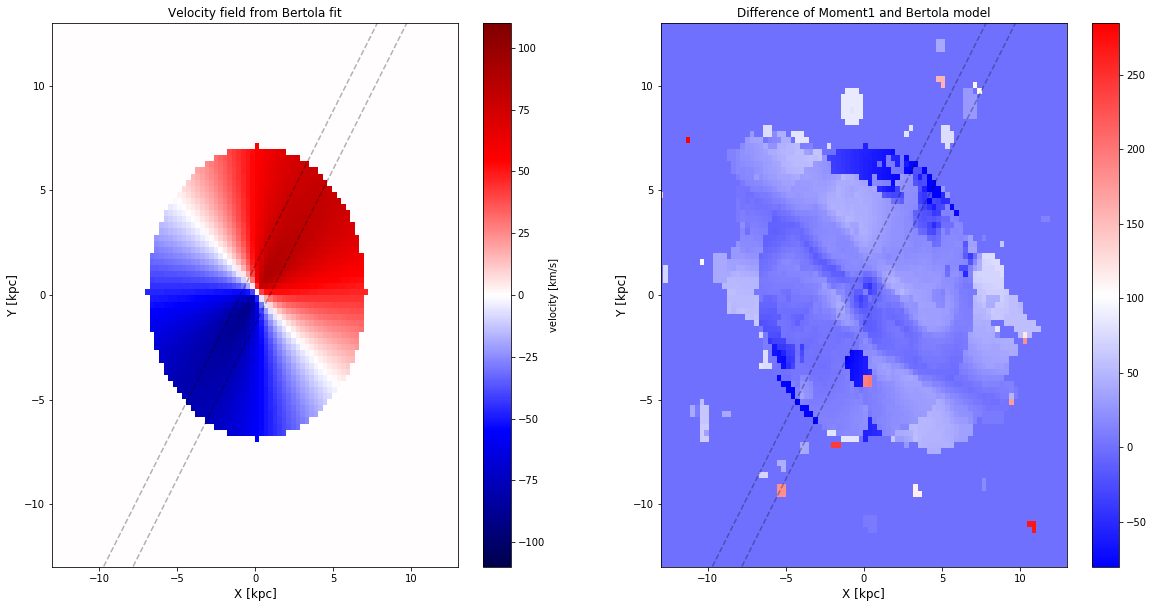

In [21]:
fit_init_params=[inc,papvds[0]]  #inclination, PA
X,Y=np.meshgrid(xx_kpc,yy_kpc)
ydata=np.where(np.isnan(mrk79_mom1),0,mrk79_mom1).ravel()
xy_mesh=np.meshgrid(xx_kpc,yy_kpc)
inc_pa,covar=curve_fit(velf_bert,xy_mesh,ydata,p0=fit_init_params,sigma=np.linspace(np.abs(dv),np.abs(dv),len(ydata)),absolute_sigma=True,bounds=(10,[90,180]))
print("Fitted parameters:\ninclination = ","{:.4}".format(inc_pa[0])," deg\nPA = ","{:.5}".format(inc_pa[1])," deg")
vf_fit=velf_bert(xy_mesh,inc_pa[0],inc_pa[1])
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(xx_kpc,yslit_low(xx_kpc),'--',alpha=0.3, color='black')
plt.plot(xx_kpc,yslit_high(xx_kpc),'--',alpha=0.3, color='black')
plt.xlim(-13,13), plt.ylim(-13,13)
plt.pcolormesh(xx_kpc,yy_kpc,vf_fit.reshape(len(xx),len(yy)),cmap='seismic',vmin=-110,vmax=110)
plt.colorbar(label='velocity [km/s]'),plt.xlabel('X [kpc]',fontsize=12),plt.ylabel('Y [kpc]',fontsize=12)
plt.title('Velocity field from Bertola fit')

plt.subplot(1,2,2)
plt.plot(xx_kpc,yslit_low(xx_kpc),'--',alpha=0.3, color='black')
plt.plot(xx_kpc,yslit_high(xx_kpc),'--',alpha=0.3, color='black')
plt.xlim(-13,13), plt.ylim(-13,13)
plt.xlabel('X [kpc]',fontsize=12),plt.ylabel('Y [kpc]',fontsize=12)
plt.pcolormesh(xx_kpc,yy_kpc,np.abs(ydata.reshape(len(xx),len(yy)))-np.abs(vf_fit.reshape(len(xx),len(yy))),cmap='bwr')
plt.colorbar()
plt.title('Difference of Moment1 and Bertola model')
plt.show()

### Optical Image & CO(1-0) moment 0

In [22]:
opticalfits=["g.fits","r.fits","i.fits","z.fits"]

g_fits=fits.open(datafolder+'optical/'+opticalfits[0])
r_fits=fits.open(datafolder+'optical/'+opticalfits[1])
i_fits=fits.open(datafolder+'optical/'+opticalfits[2])
z_fits=fits.open(datafolder+'optical/'+opticalfits[3])

#fits.HDUList.info(r_fits)

gheader=g_fits[0].header
rheader=r_fits[0].header
iheader=i_fits[0].header
zheader=z_fits[0].header

gdata=g_fits[0].data
rdata=r_fits[0].data
idata=i_fits[0].data
zdata=z_fits[0].data

g_fits.close()
r_fits.close()
i_fits.close()
z_fits.close()

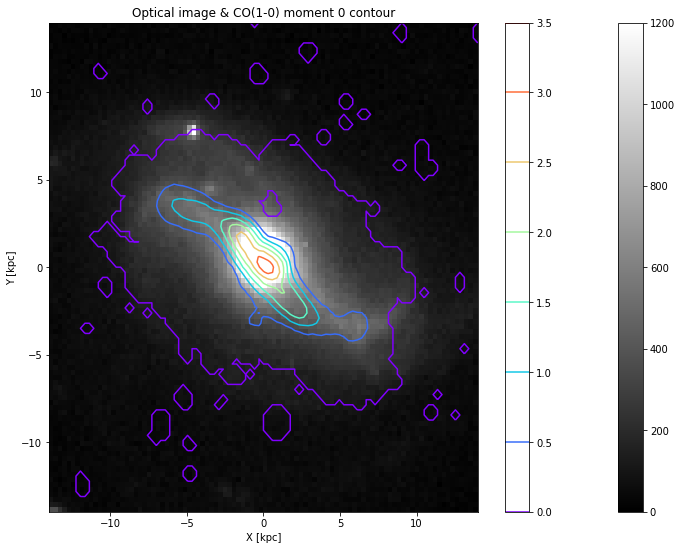

In [23]:
final_image=gdata+rdata+idata+zdata
plt.figure(figsize=(12,9))
center=[np.int(rheader["CRPIX1"]),np.int(rheader["CRPIX1"])]
final_image2=final_image[center[0]-48:center[0]+48, center[0]-48:center[0]+48]

plt.pcolormesh(xx_kpc,yy_kpc,final_image2,cmap='gray',vmin=0,vmax=1200), plt.colorbar()
plt.contour(xx_kpc,yy_kpc,np.rot90(mrk79_mom0,k=2,axes=(0,1)),cmap='rainbow'), plt.colorbar()
plt.xlabel("X [kpc]"), plt.ylabel("Y [kpc]"), plt.title("Optical image & CO(1-0) moment 0 contour")
display()

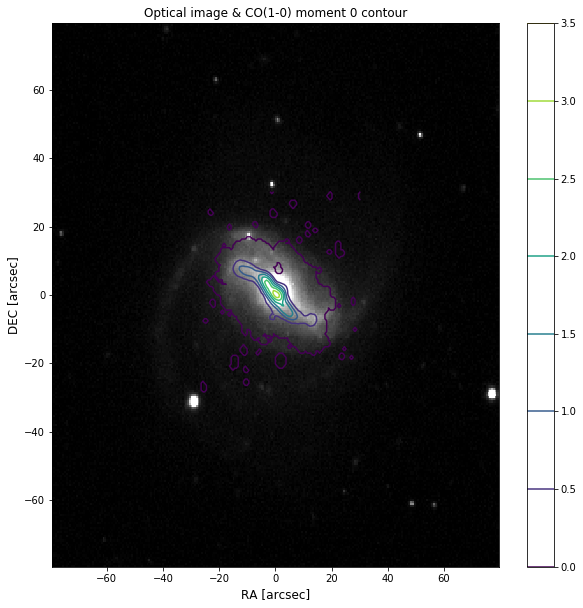

In [24]:
plt.figure(figsize=(10,10))
xx1=np.linspace(-rdata.shape[1]*dx/2.,rdata.shape[1]*dx/2.,255)#*ak #arcsec
yy1=np.linspace(-rdata.shape[1]*dx/2.,rdata.shape[1]*dx/2.,255)#*ak 
plt.pcolormesh(xx1,yy1,final_image,cmap='gray',vmin=0,vmax=800)
plt.contour(xx,yy,np.rot90(mrk79_mom0,k=-2,axes=(0,1))), plt.colorbar()
plt.xlabel("RA [arcsec]",fontsize=12), plt.ylabel("DEC [arcsec]",fontsize=12), plt.title("Optical image & CO(1-0) moment 0 contour")
display()